Start with in-game stats dataset of 10754 players (not including goalkeepers) from 2022-2023 season.
After merging with player description dataset and preprocessing, drops to 7400 rows (unique players).
Then, keep only players that have played at least 8 games (1/4 of season).
Split dataset into 4, 1 for each position group.
Import 4 datasets regarding attackers, midfielders, defenders, and goalies.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

defe = pd.read_csv("2022_defenders.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
best_defenders = ['Theo Hernández', 'Trent Alexander-Arnold', 'Virgil van Dijk', 'Andrew Robertson',
                 'Nathan Aké', 'John Stones', 'Kyle Walker', 'Éder Militão', 'Antonio Rüdiger', 'David Alaba',
                 'Marquinhos', 'Achraf Hakimi', 'Kieran Trippier', 'William Saliba', 'Giovanni Di Lorenzo',
                 'Jules Koundé', 'Jordi Alba', 'Benjamin Pavard', 'Matthijs de Ligt', 'Alphonso Davies', 
                 'Dayot Upamecano', 'Raphaël Guerreiro', 'Nahuel Molina', 'Micky van de Ven', 'Reece James',
                 'Joško Gvardiol', 'Cristian Romero', 'Rúben Dias', 'Manuel Akanji', 'Danilo',
                 'Pierre Kalulu','Thiago Silva', 'Pau Torres', 'Lisandro Martínez', 'Nayef Aguerd',
                 'Dani Carvajal', 'Denzel Dumfries', 'Alessandro Bastoni', 'Oleksandr Zinchenko', 'Pervis Estupiñán']

for index, row in defe.iterrows():
    if row['Player'] in best_defenders:
        defe.loc[index,'Success'] = 1
    else:
        defe.loc[index,'Success'] = 0

In [2]:
len(best_defenders)

40

In [3]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

X = defe.drop('Success', axis=1)
y = defe['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_new = X_train.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot", 
                            'Nat', 'Based', 'Medium Cmp%', 'Short Cmp%', 'Long Cmp%'], axis=1)
X_train_new.columns = X_train_new.columns.str.strip()

X_test_new = X_test.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot",
                          'Nat', 'Based', 'Medium Cmp%', 'Short Cmp%', 'Long Cmp%'], axis=1)
X_test_new.columns = X_test_new.columns.str.strip()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import pandas as pd

# Standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_new), columns=X_train_new.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_new), columns=X_test_new.columns)

# Define class weights
class_weights = {0: 1, 1: 50}

# Define the models
models = {
    'Logistic Regression - Newton': LogisticRegression(solver='newton-cg',penalty=None,max_iter=1000, class_weight=class_weights), 
    'Logistic Regression - lbgfs': LogisticRegression(solver='lbfgs',penalty=None,max_iter=2000,class_weight=class_weights), 
    'Logistic Regression - sag': LogisticRegression(solver='sag',penalty=None,max_iter=2000,class_weight=class_weights), 
    'Logistic Regression - saga': LogisticRegression(solver='saga',penalty=None,max_iter=3000,class_weight=class_weights),
    'Logistic Regression' : LogisticRegression(class_weight=class_weights),
    'SVM': SVC(kernel='linear',probability=True,class_weight=class_weights)
}

for model_name, model in models.items():

    model.fit(X_train_scaled, y_train)

    # Fit SVM model
    svm_model = SVC(kernel='linear',probability=True)  # Set probability=True to enable probability estimates
    svm_model.fit(X_train_scaled, y_train)

    # Calculate AIC/BIC
    log_likelihood = np.sum(y_test * np.log(model.predict_proba(X_test_scaled)[:, 1]) + (1 - y_test) * np.log(1 - model.predict_proba(X_test_scaled)[:, 1]))
    num_params = len(model.coef_[0]) + 1
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(len(y_test))

    # Print AIC/BIC values
    print("\nAIC for " + model_name + ": " + str(aic))
    print("BIC for " + model_name + ": " + str(bic))


AIC for Logistic Regression - Newton: 324.79663000918305
BIC for Logistic Regression - Newton: 431.4639789290517

AIC for Logistic Regression - lbgfs: 324.77330918825817
BIC for Logistic Regression - lbgfs: 431.4406581081268


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



AIC for Logistic Regression - sag: 510.2749296408206
BIC for Logistic Regression - sag: 616.9422785606891


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



AIC for Logistic Regression - saga: 435.41372814120035
BIC for Logistic Regression - saga: 542.081077061069

AIC for Logistic Regression: 309.73879051875906
BIC for Logistic Regression: 416.4061394386277

AIC for SVM: 112.24495125969874
BIC for SVM: 218.91230017956735


In [5]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import shap

# Fit logistic regression model using scikit-learn
masker = shap.maskers.Independent(data = X_train_scaled)
model = SVC(kernel='linear',probability=True,class_weight=class_weights)
model.fit(X_train_scaled, y_train)
explainer = shap.LinearExplainer(model, masker=masker)
shap_values = explainer(X_test_scaled)

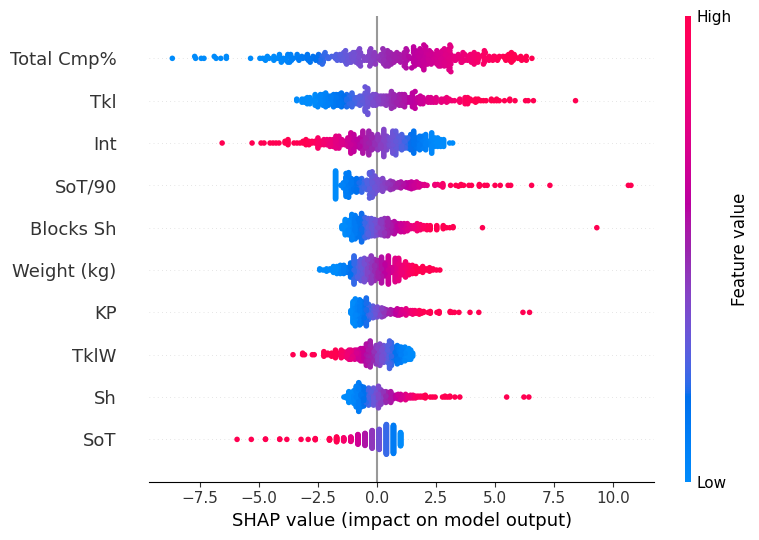

In [6]:
shap.summary_plot(shap_values, max_display=10, show=False)

import matplotlib.pyplot as pl
pl.savefig("shap_summary3.png",dpi=700)

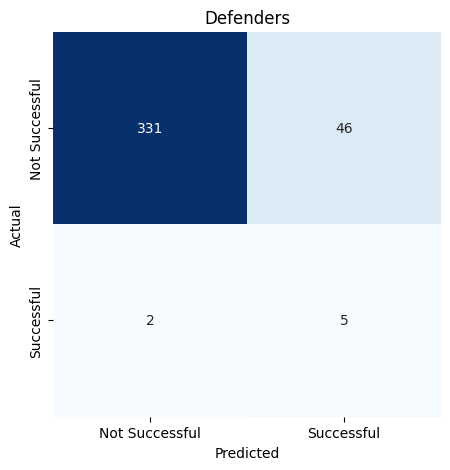

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.title(f'Defenders')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision,3))

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,3))

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", round(f1,3))

Accuracy: 0.875
Precision: 0.098
Recall: 0.714
F1-Score: 0.172
